# Multi-Agents

## Goal

We'll combine several themes from this course into a multi-agent researcher:

1) `Human In The Loop` --  A human will provide an overall topic to research. We will generate a set of AI analysts that research specific sub-topics related to the provided topic. We'll use human-in-the-loop to review and refine these sub-topics before the research phase.

2) `Sub-graphs` -- Each analyst will interview an expert on their sub-topic of focus. These interviews will be encapsulated in sub-graphs, with their own internal `messages` state, and may be multi-turn as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.

3) `Parallelization` -- Each expert will use different knowledge gathering tools in parallel, such as search and retrieval, to answer questions from the analyst.
 
4) `Map-reduce` -- The interviews will be done in parallel using map-reduce, resulting in a multi-agent workflow. Each analyst will distill the interview into a section of the final report. These sections will be added to an overall report. A final refinement phase will be used to add an introduction and conclusion.

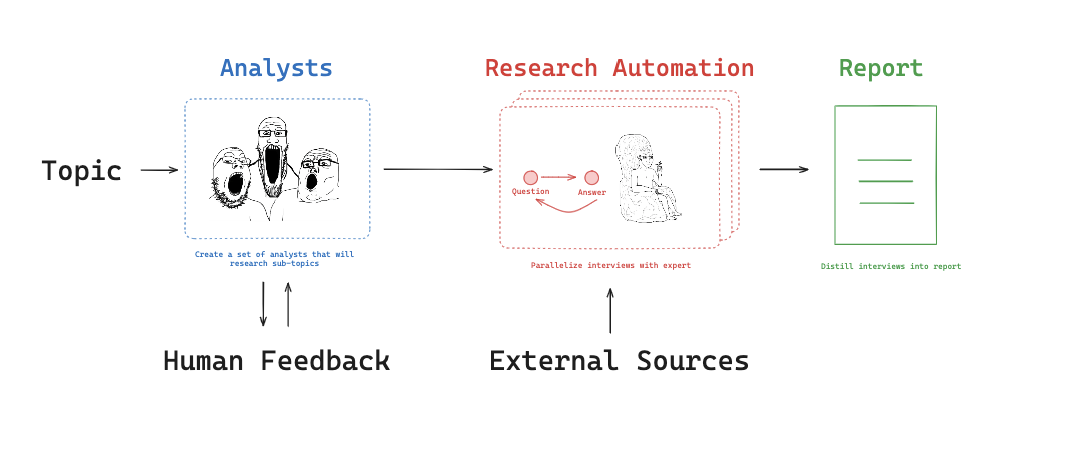

In [38]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai pypdf langchain_community langchain_core scikit-learn tavily-python wikipedia

## LLM

Ensure your `OPENAI_API_KEY` is set.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

## Generate Analysts: Human-In-The-Loop

Create analysts and review them. 

In [2]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

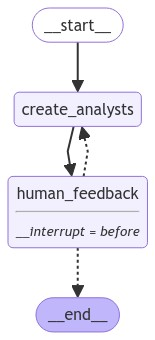

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    
    instructions = SystemMessage(content=f"""
    
    You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
      
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    analysts = structured_llm.invoke([instructions]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
# Input
max_analysts = 3 

topic = '''I want a report focused on the innovations related to the Meta LLlama3.1 work, 
especially on training infrastructue, model architecture, and quantization approaches.'''

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: OpenAI Research
Role: Training Infrastructure Specialist
Description: Dr. Carter focuses on the development and optimization of large-scale training infrastructure. Her primary concern is to ensure that the infrastructure can handle the computational demands of training advanced models like Meta LLlama3.1 efficiently and cost-effectively.
--------------------------------------------------
Name: Dr. Rajesh Patel
Affiliation: DeepMind
Role: Model Architecture Expert
Description: Dr. Patel specializes in the design and evaluation of neural network architectures. His work involves exploring innovative architectural changes that can improve the performance and efficiency of models like Meta LLlama3.1.
--------------------------------------------------
Name: Dr. Sophia Martinez
Affiliation: Google AI
Role: Quantization Techniques Analyst
Description: Dr. Martinez is an expert in model quantization techniques. She focuses on developing methods to reduce the

In [5]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [6]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c54-3530-6d00-8002-61abb93a3749'}}

In [7]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.
--------------------------------------------------
Name: Michael Thompson
Affiliation: NVIDIA
Role: Senior Infrastructure Engineer
Description: Michael is an expert in AI training infrastructure. He examines the hardware and software optimizations that support the training of large-scale models like LLlama3.1, including distributed computing and GPU acceleration.
--------------------------------------------------
Name: Samantha Lee
Affiliation: AI Startup InnovateAI
Role: CEO and Co-Founder
Description: Samantha brings an entrepreneurial perspective, focusing on the practical applications and commercialization of innovations in quantization approaches. She is interested in how these advancements can be l

In [8]:
# If we are satisfied, then we simply supply no feedback to end
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64c54-6013-634c-8004-897c7b26fec2'}}

In [9]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [11]:
final_state.next

()

In [12]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Zhang
Affiliation: Meta
Role: Lead Research Scientist
Description: Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.
--------------------------------------------------
Name: Michael Thompson
Affiliation: NVIDIA
Role: Senior Infrastructure Engineer
Description: Michael is an expert in AI training infrastructure. He examines the hardware and software optimizations that support the training of large-scale models like LLlama3.1, including distributed computing and GPU acceleration.
--------------------------------------------------
Name: Samantha Lee
Affiliation: AI Startup InnovateAI
Role: CEO and Co-Founder
Description: Samantha brings an entrepreneurial perspective, focusing on the practical applications and commercialization of innovations in quantization approaches. She is interested in how these advancements can be l

## Conduct Interview

### Generate Question

The analyst will ask questions.

In [4]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.retrievers import BaseRetriever
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class InterviewState(MessagesState):
    topic: str # Research topic
    retriever: BaseRetriever # Retriever
    max_num_turns = int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [5]:
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 

    Your goal is boil down to interesting and specific insights related to your topic.

    1. Interesting: Insights that people will find surprising or non-obvious.
            
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Here is your topic of focus and set of goals: {analyst.persona}
            
    Begin by introducing yourself using a name that fits your persona, and then ask your question.

    Continue to ask questions to drill down and refine your understanding of the topic.
            
    When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")

    # Generate question 
    question = llm.invoke([instructions]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel.

Here we can be very flexible. For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents
* Web search
* Wikipedia search

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

Optionally, build an index from any docs that you want the expert to use.

Simply pass the index into the assistant when you run.

In [6]:
# Index
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Load llama3.1 paper (pdf)
loader = PyPDFLoader("../assistant/docs/llama3_1.pdf")
pages = loader.load_and_split()

# Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Full paper, except for references 
all_pages_except_references=pages[:100]

# Index
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references, 
                                                embedding=embeddings)

# Build retriever
retriever = vectorstore.as_retriever(k=10)

In [7]:
# Web search tool

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [8]:
# Wikipedia search tool

from langchain_community.document_loaders import WikipediaLoader

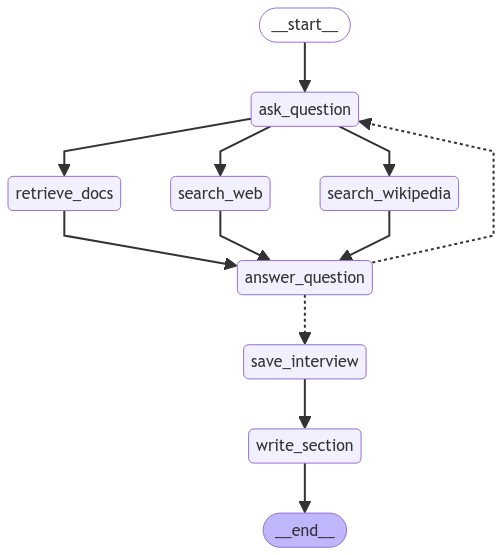

In [9]:
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string

# Search query writing
instructions = SystemMessage(content=f"""

You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def retrieve_docs(state: InterviewState):
    
    """ Get docs """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+state['messages'])
    retriever = state.get('retriever',None)

    # If retriever exists
    if retriever:
    
        # Retrieve
        docs = retriever.invoke(search_query.search_query)
    
        # Format
        formatted_retrieved_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
                for doc in docs
            ]
        )
    
        return {"context": [formatted_retrieved_docs]} 
    
        formatted_retrieved_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
                for doc in EXPERT_DOC_CONTEXT
            ]
        )

    else:

        # Just return empty context
        formatted_retrieved_docs = ""
        
    return {"context": [formatted_retrieved_docs]} 

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    instructions = SystemMessage(content=f"""
    
    You are an expert being interviewed by an analyst who focused on learning this topic: {topic}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preanble in your citation.""")
   
    # Answer question
    answer = llm.invoke([instructions]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    instructions = SystemMessage(content=f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    4. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
       
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed""")
   
    # Write section using either the gathered source docs from interview, or the interview itself 
    section = llm.invoke([instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("retrieve_docs", retrieve_docs)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "retrieve_docs")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("retrieve_docs", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [20]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Meta', name='Dr. Emily Zhang', role='Lead Research Scientist', description='Dr. Zhang focuses on the technical advancements and innovations in model architecture. She is particularly interested in how the new architectural changes in LLlama3.1 improve performance and efficiency.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [87]:
from IPython.display import Markdown

# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
initial_state = {"analyst": analysts[0], "messages": messages, "retriever": retriever}
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(initial_state, thread)
Markdown(interview['sections'][0])

## Optimizing AI Model Architectures: Insights from Meta's Llama 3.1

### Summary

The development and optimization of model architectures are crucial for advancing artificial intelligence (AI) systems. Foundation models, which serve as the backbone for various AI tasks, have seen significant improvements with the introduction of Meta's Llama 3.1. This report delves into the novel aspects of Llama 3.1, highlighting its advancements in efficiency and performance.

Llama 3.1 represents a significant leap in the evolution of foundation models, particularly in its ability to handle multilinguality, coding, reasoning, and tool usage. The flagship model, a dense Transformer with 405 billion parameters, boasts a context window of up to 128,000 tokens, a substantial increase from its predecessors. This enhancement allows the model to process and generate more complex and contextually rich outputs [1].

Key innovations in Llama 3.1 include:

1. **Data Quality and Quantity**: Llama 3.1 was pre-trained on a corpus of approximately 15 trillion multilingual tokens, a significant increase from the 1.8 trillion tokens used for Llama 2. This improvement in data quality and quantity was achieved through more rigorous pre-processing and curation pipelines, as well as enhanced quality assurance and filtering approaches [1].

2. **Scale and Compute Efficiency**: The model was trained using 3.8×10²⁵ FLOPs, nearly 50 times more than the largest version of Llama 2. This massive scale of training, facilitated by Meta's advanced AI infrastructure, ensures that Llama 3.1 can handle more complex tasks with higher accuracy and efficiency [1].

3. **Multimodal Capabilities**: Llama 3.1 integrates image, video, and speech capabilities through a compositional approach. This multimodal functionality allows the model to perform competitively with state-of-the-art systems in image, video, and speech recognition tasks, although these features are still under development and not yet broadly released [1].

4. **Tool Use and Zero-Shot Learning**: The model supports zero-shot tool use, enabling it to integrate seamlessly with tools it has not encountered during training. This capability is particularly beneficial for tasks requiring specific tool calls, such as search, image generation, code execution, and mathematical reasoning [2].

5. **Performance Benchmarks**: Llama 3.1 demonstrates competitive performance across various benchmarks, often matching or surpassing leading models like GPT-4. For instance, in the ARC Challenge benchmark, Llama 3.1 achieved a normalized negative log-likelihood that closely predicts its performance, showcasing its robustness and reliability [1].

6. **Safety and Alignment**: Post-training stages of Llama 3.1 include alignment with human feedback through supervised fine-tuning and Direct Preference Optimization (DPO). These steps ensure that the model not only performs well but also aligns with human preferences and safety standards [1].

In summary, Llama 3.1's advancements in data quality, scale, multimodal capabilities, and tool use represent significant strides in the development of foundation models. These innovations are poised to enhance the efficiency and performance of AI systems, aligning with Dr. Zhang's focus on optimizing model architectures.

### Sources
[1] https://llama.meta.com/  
[2] https://www.ibm.com/blog/meta-releases-llama-3-1-models-405b-parameter-variant/  
[3] https://www.datacamp.com/blog/llama-3-1-405b-meta-ai  
[4] https://datasciencedojo.com/blog/meta-llama-3-1/

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Reflection

We add a final step to reflect on the sections.

And we write an intro and conclusion. 

In [10]:
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    retriever: BaseRetriever # Retriever
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

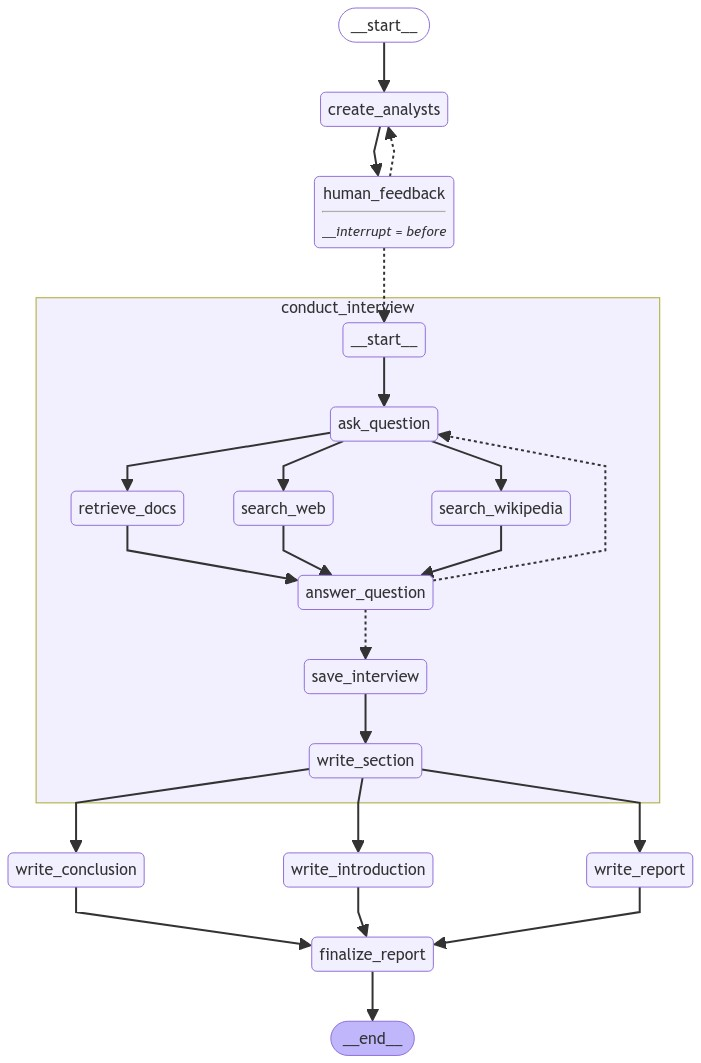

In [11]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]


report_instructions_template = """You are a technical writer finishing a report on {topic}
    
You will be given several memos, each written by an individual analyst.

You job is to consolidate these into a crisp, overall report that ties together the memos. 

The report should summarize the central points in each memo into a cohesive single narrative.

Use markdown formatting. 

Include no pre-amble for the report.

Start your report with the ## Insights header.

Do not mention any analyst names in your report.

Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].

Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.

List your sources in order and do not repeat.

[1] Source 1
[2] Source 2


Here are the memos to summarize: {formatted_str_sections}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    report_instructions = report_instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=report_instructions)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}


instructions_template = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = instructions_template.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n" + content + "\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

Here, we do not supply a retriever and will reply on web / wikipedia search.

In [12]:
# Inputs
max_analysts = 3 

topic = '''The benefits of adopting LangGraph as an agent framework'''

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Efficiency Expert
Description: Dr. Carter focuses on the efficiency gains that can be achieved through adopting new technologies. She is particularly interested in how LangGraph can streamline processes and reduce operational costs.
--------------------------------------------------
Name: Raj Patel
Affiliation: Data Security Solutions
Role: Security Analyst
Description: Raj Patel examines the security implications of adopting new frameworks. His primary concern is how LangGraph can enhance or compromise data security within an organization.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Future Tech Research Group
Role: Innovation Specialist
Description: Sophia Martinez explores the innovative potential of emerging technologies. She is keen on understanding how LangGraph can drive innovation and provide a competitive edge to businesses.
--------------------------------------------------

In [13]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64f31-b1c6-6c86-8002-4beadaa92961'}}

In [14]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Thompson
Affiliation: Gen AI Native Startup
Role: CEO
Description: Alex is the CEO of a startup that specializes in generative AI technologies. He is focused on leveraging cutting-edge frameworks to enhance the capabilities of his company's AI solutions. His primary concern is the scalability and efficiency of the frameworks his team adopts.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Tech Research Institute
Role: Senior Researcher
Description: Dr. Carter is a senior researcher at a leading tech research institute. Her work revolves around evaluating new AI frameworks and their impact on research and development. She is particularly interested in the technical benefits and potential for innovation that LangGraph offers.
--------------------------------------------------
Name: Michael Lee
Affiliation: Enterprise Software Solutions
Role: CTO
Description: Michael is the CTO of a large enterprise software company. He is responsible for 

In [15]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef64f31-f1af-6df2-8004-24ac9d9901a7'}}

In [16]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [17]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the rapidly evolving field of generative AI, the need for scalable and efficient frameworks is paramount. LangGraph, a specialized library within the LangChain ecosystem, offers a promising solution for developing advanced AI agents. This report explores the capabilities and advantages of LangGraph, focusing on its ability to create state machines with Large Language Models (LLMs) as reasoning engines, its compatibility with LangChain V2, and its proficiency in building stateful, multi-actor applications. Additionally, we delve into how LangGraph optimizes AI agent performance through granular control, and its ability to maintain state, memory, and context, thereby enhancing the quality and scalability of AI applications.



In the rapidly evolving field of generative AI, the need for scalable and efficient frameworks is paramount. LangGraph, a specialized library within the LangChain ecosystem, offers a promising solution for developing advanced AI agents. This report consolidates insights from various analyses to highlight the capabilities and advantages of LangGraph, emphasizing its potential to enhance the performance, scalability, and integration of AI applications.

### State Machines and Developer Control

LangGraph enables developers to create state machines where Large Language Models (LLMs) act as reasoning engines, striking a balance between leveraging the power of LLMs and maintaining developer control over the application flow [1]. This granular control is crucial for optimizing AI guest-facing solutions, where maintaining state, memory, and context is essential for delivering high-quality outputs [2].

### Compatibility with LangChain V2

The framework is designed to work seamlessly with LangChain V2, making it ideal for developing research agents that provide detailed, multi-step responses [3]. This compatibility ensures that researchers can leverage the latest advancements in AI frameworks to build more flexible and controllable AI systems [4].

### Stateful, Multi-Actor Applications

LangGraph excels in building stateful, multi-actor applications, coordinating and checkpointing different chains or actors using regular Python functions [5]. This capability is particularly beneficial for developing reliable, fault-tolerant agent-based systems [6].

### Performance Optimization

One of the standout features of LangGraph is its ability to optimize AI agent performance. By enabling granular control over the agent's thought process, LangGraph allows for data-driven and deliberate decision-making, which is crucial for meeting diverse user needs [7]. Additionally, the framework's integration with scalable and reliable database solutions like Amazon RDS and Google Cloud SQL, as well as the implementation of content delivery networks (CDNs), significantly enhances the performance of applications, especially for globally distributed users [8].

### Maintaining State, Memory, and Context

LangGraph addresses common drawbacks in LLM-based applications by maintaining state, memory, and context, thereby improving output quality and performance [9]. This feature is particularly beneficial for AI research agents that perform detailed, multi-step research tasks, significantly enhancing the depth and quality of research outputs [10].

### Simplified AI Agent Management

LangGraph simplifies the creation and management of AI agents and their runtimes through its unique design, which is well-suited for creating reliable, fault-tolerant systems [11]. Its full integration into the LangChain ecosystem allows users to leverage existing LangChain integrations and LangSmith observability, making it a comprehensive solution for multi-agent workflows [12].

### Practical Utility in Research Settings

LangGraph's integration with tools like fetch_arxiv, which allows agents to retrieve summaries of specific papers from the ArXiv repository, exemplifies its practical utility in research settings. By sending a GET request to ArXiv and using regex for data extraction, LangGraph enables seamless access to relevant academic papers, thereby streamlining the research process [13].

In summary, LangGraph offers a novel and powerful approach to building AI research agents, with its unique features of cycles, controllability, and persistence setting it apart from other frameworks. Its ability to automate complex research tasks and integrate with existing tools makes it a valuable asset for researchers looking to push the boundaries of AI innovation.


## Conclusion

LangGraph emerges as a transformative framework in the realm of AI, offering unparalleled benefits for scalable and efficient AI solutions. By enabling developers to create state machines with Large Language Models (LLMs) as reasoning engines, LangGraph strikes a balance between leveraging LLM power and maintaining developer control. Its compatibility with LangChain V2 and ability to build stateful, multi-actor applications make it ideal for developing advanced research agents. Furthermore, LangGraph's focus on performance optimization, state maintenance, and seamless integration with scalable solutions like Amazon RDS and Google Cloud SQL enhances its utility. In summary, LangGraph stands out as a robust, comprehensive solution for developing sophisticated, high-performance AI agents.

## Sources

[1] [Understanding LangGraph](https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/)  
[2] [LangGraph Overview](https://www.langchain.com/langgraph)  
[3] [Using LangGraph to Build AI Agents](https://www.geeky-gadgets.com/using-langgraph-to-build-ai-agents/)  
[4] [A Practical Guide to Building AI Agents with LangGraph](https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/)  
[5] [LangGraph AI Agent Optimization and Performance Tuning](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)  
[6] [Mastering LangGraph: A Production-Ready Coding Walkthrough for Software Engineers](https://ragaboutit.com/mastering-langgraph-a-production-ready-coding-walkthrough-for-software-engineers/)  
[7] [LangGraph AI Agent Optimization and Performance Tuning](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)  
[8] [Mastering LangGraph: A Production-Ready Coding Walkthrough for Software Engineers](https://ragaboutit.com/mastering-langgraph-a-production-ready-coding-walkthrough-for-software-engineers/)  
[9] [LangGraph Overview](https://www.langchain.com/langgraph)  
[10] [LangGraph Overview](https://www.langchain.com/langgraph)  
[11] [A Practical Guide to Building AI Agents with LangGraph](https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/)  
[12] [LangGraph Multi-Agent Workflows](https://blog.langchain.dev/langgraph-multi-agent-workflows/)  
[13] [LangGraph Research Agent](https://www.pinecone.io/learn/langgraph-research-agent/)

We can look at the trace:

https://smith.langchain.com/public/167e0a0e-7d40-4e89-b29c-bd81dae1cc46/r